In [64]:
import networkx
import pandas as pd
import seaborn as sns

In [142]:
# Helper functions
def facet_plot(data: pd.DataFrame, xval: str, column: str = 'category') -> sns.axisgrid.FacetGrid:
    """Helper function to plot faceted histograms"""
    g = sns.FacetGrid(data, col=column)
    plot = g.map(sns.histplot, xval)
    return plot


In [115]:
# Read in by-country file
df = pd.read_csv("../data/all-weeks-countries.tsv", sep='\t')
df.week = pd.to_datetime(df.week)
df.loc[:, 'item_title'] = df.apply(lambda x: x.season_title if type(x.season_title)!=float else x.show_title, axis=1)

In [21]:
# Top line descriptive stats
unique_values = df.nunique()
by_type = df.groupby('category').nunique()
print(f"""
Countries: {unique_values.country_name}
Weeks: {unique_values.week}
Items: {unique_values.show_title}
    {round(by_type.iloc[0].show_title / unique_values.show_title * 100, 1)}% movies
    {round(by_type.iloc[1].show_title / unique_values.show_title * 100, 1)}% TV shows
""")


Countries: 94
Weeks: 36
Items: 2355
    76.0% movies
    24.4% TV shows



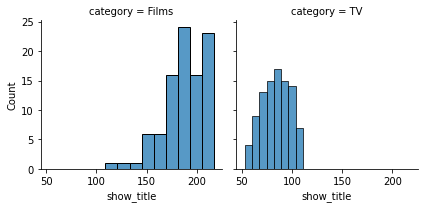

In [144]:
# Distribution of item count by country
items_by_country = df.groupby(['country_name', 'category']).nunique().show_title.reset_index()
facet_plot(items_by_country, 'show_title')

<AxesSubplot:>

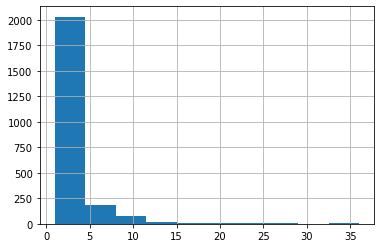

In [37]:
# Cumulative week distribution across countries
df.groupby('show_title').cumulative_weeks_in_top_10.max().hist()

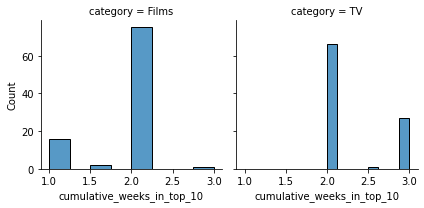

In [145]:
# Any variation in staying power by item type/country? (median cumulative weeks)
weeks_by_country_item = df.groupby(['country_name', 'item_title']).cumulative_weeks_in_top_10.max().reset_index()
weeks_by_country_item = weeks_by_country_item.set_index('item_title').join(df[['item_title', 'category']].drop_duplicates().set_index('item_title'))
mean_presence_by_country = weeks_by_country_item.groupby(['country_name', 'category']).median().reset_index()
facet_plot(mean_presence_by_country, 'cumulative_weeks_in_top_10')

<AxesSubplot:>

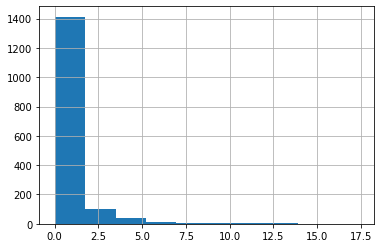

In [120]:
# Any variation in staying power by country at the item level?
variation_by_country = weeks_by_country_item.groupby(level=0).agg({'cumulative_weeks_in_top_10': ['count', 'std']})
variation_by_country.columns  = variation_by_country.columns.get_level_values(1)
variation_by_country[variation_by_country['count']>1]['std'].hist()

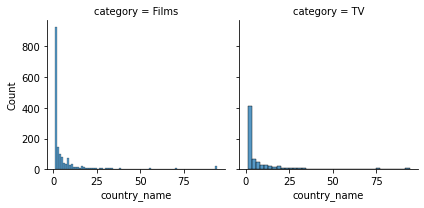

In [146]:
# Number of countries by item
countries_per_item = df.groupby(['category', 'item_title']).nunique().country_name.reset_index()
facet_plot(countries_per_item, 'country_name')

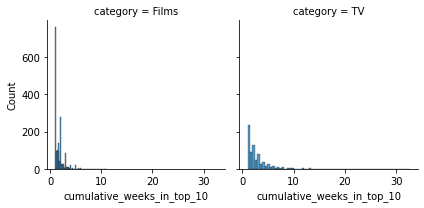

In [147]:
# Tenure distribution
mean_tenures = df.groupby(['category', 'item_title', 'country_name']).cumulative_weeks_in_top_10.max().groupby(level=[0, 1]).mean().reset_index()
facet_plot(mean_tenures, 'cumulative_weeks_in_top_10')

C:\Users\Nick\anaconda3\envs\netflix\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


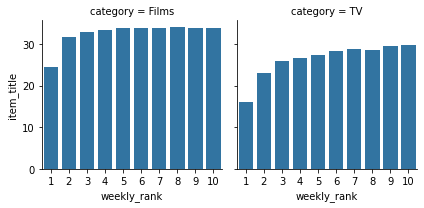

In [154]:
# Rank occupants
occupants = df.groupby(['category', 'weekly_rank', 'country_name']).item_title.nunique()
mean_occupants = occupants.groupby(level=[0, 1]).mean().reset_index()
g = sns.FacetGrid(mean_occupants, col='category')
g.map(sns.barplot, 'weekly_rank', 'item_title')

In [170]:
# Rank swaps
df.sort_values(by='week')

,country_name,country_iso2,week,category,weekly_rank,show_title,season_title,cumulative_weeks_in_top_10,item_title
33829,Luxembourg,LU,2021-07-04,Films,10,Skater Girl,NaN,1,Skater Girl
23746,Iceland,IS,2021-07-04,Films,7,Kung Fu Panda 3,NaN,1,Kung Fu Panda 3
23747,Iceland,IS,2021-07-04,Films,8,Three Identical Strangers,NaN,1,Three Identical Strangers
23748,Iceland,IS,2021-07-04,Films,9,Fear Street Part 1: 1994,NaN,1,Fear Street Part 1: 1994
23749,Iceland,IS,2021-07-04,Films,10,The Mitchells vs. The Machines,NaN,1,The Mitchells vs. The Machines
...,...,...,...,...,...,...,...,...,...
53996,Slovakia,SK,2022-03-06,TV,7,The Cuphead Show!,The Cuphead Show!: Season 1,2,The Cuphead Show!: Season 1
53995,Slovakia,SK,2022-03-06,TV,6,Love Is Blind,Love Is Blind: Season 2,3,Love Is Blind: Season 2
53994,Slovakia,SK,2022-03-06,TV,5,One of Us Is Lying,One of Us Is Lying: Season 1,3,One of Us Is Lying: Season 1
8646,Colombia,CO,2022-03-06,Films,7,Abominable,NaN,3,Abominable


C:\Users\Nick\anaconda3\envs\netflix\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


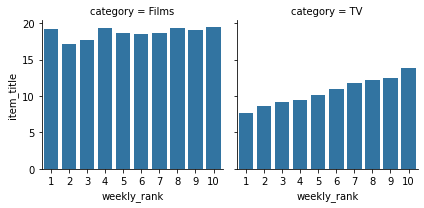

In [169]:
# First ranks distribution
mean_first_counts = (df[df.cumulative_weeks_in_top_10==1].groupby(['category', 'country_name', 'weekly_rank']).count().item_title \
        .groupby(level=[0, 2]).mean().reset_index())
g = sns.FacetGrid(mean_first_counts, col='category')
g.map(sns.barplot, 'weekly_rank', 'item_title')

In [168]:
# Rank transition probabilities
mean_first_counts

,category,weekly_rank,item_title
0,Films,1,19.191489
1,Films,2,17.117021
2,Films,3,17.755319
3,Films,4,19.297872
4,Films,5,18.606383
5,Films,6,18.468085
6,Films,7,18.648936
7,Films,8,19.351064
8,Films,9,19.063830
9,Films,10,19.414894


In [ ]:
# Rank churn
